In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet_uniform import *
from NN_library.ConvNet.ConvNet_uniform import *
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload 2

Using device: cuda
Using device: cuda


Test U-Net

In [2]:
name = 'NN_library/AutoUnet/AutoUnet_uniform_27'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
unet = AutoUNet()
unet = load_network(unet, args['name'], args)
unet = unet.to(dev)

name = 'NN_library/ConvNet/ConvNet_uniform'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
convnet = ConvNet(16)
convnet = load_network(convnet, args['name'], args)
convnet = convnet.to(dev)

In [3]:
def add_interface(geometry_bw):
    geometry_ud = geometry_bw[1:] - geometry_bw[:-1]
    geometry_diff = torch.zeros_like(geometry_bw, device=dev)
    geometry_diff[:-1] += torch.where(geometry_ud==1., 1., 0.)
    geometry_diff[1:] += torch.where(geometry_ud==-1., 1., 0.)
    geometry_bw1 = geometry_bw + geometry_diff
    geometry_lr = geometry_bw1[:,1:] - geometry_bw1[:,:-1]
    geometry_diff[:,:-1] += torch.where(geometry_lr==1., 1., 0.)
    geometry_diff[:,1:] += torch.where(geometry_lr==-1., 1., 0.)
    geometry_diff = torch.where(geometry_diff>0., 1., 0.)
    return geometry_bw+0.5*geometry_diff

In [4]:
imp_shrinkage_values = pd.read_csv('reduxed_results/uniform/damage_fields/stiffness_0.csv', sep='\t', usecols=['#shr_imposed[-]']).values.tolist()
imp_shrinkage_matrices = [np.full((99, 99), value) for value in imp_shrinkage_values]
imp_shrinkage_matrices_stacked = np.stack(imp_shrinkage_matrices)
imp_shrinkage = torch.tensor(imp_shrinkage_matrices_stacked, dtype=torch.float).to(dev)
init_damage = torch.zeros((99,99),device=dev)

In [5]:
all_damage = []
N_total = 1000
total_damage = np.zeros((N_total,3))
shrinkage = np.zeros((N_total,3))
stiffness = np.zeros((N_total,3))
volume = np.zeros((N_total,3))
for i in range(1000):
    for j in range(3):
        r = j*0.2
        filename = f'smoothen/{i}_{r:.1f}.mat'
        if os.path.isfile(filename):
            geometry = loadmat(f'smoothen/{i}_{r:.1f}.mat')['newImg'][:99,:99]
            geom_tensor = 1.-torch.tensor(geometry, dtype=torch.float, device=dev)
            geom_tensor = add_interface(geom_tensor)
            for n in range(10):
                if n == 0:
                    x = torch.stack([geom_tensor, imp_shrinkage[1,:,:] / -0.001, init_damage], axis=0).unsqueeze(0)
                else:
                    x = torch.stack([geom_tensor, imp_shrinkage[n+1,:,:] / -0.001, y[0,0].detach()], axis=0).unsqueeze(0)
                y = unet(x)
            x_shr = torch.stack([geom_tensor, imp_shrinkage[n+1,:,:] / -0.001, y[0,0].detach()], axis=0).unsqueeze(0)
            y_shr = convnet(x_shr)
            all_damage.append(y[0,0].detach().cpu())
            total_damage[i, j] = y[0,0].sum().item()
            shrinkage[i,j] = (y_shr[:,1]*(-0.001)).item()
            stiffness[i,j] = (y_shr[:,0]).item()
            volume[i,j] = geometry.sum() / 99**2
        else:
            total_damage[i, j] = np.NAN
            shrinkage[i,j] = np.NAN
            stiffness[i,j] = np.NAN
            volume[i,j] = np.NAN

Text(0.5, 1.0, 's = 0.4')

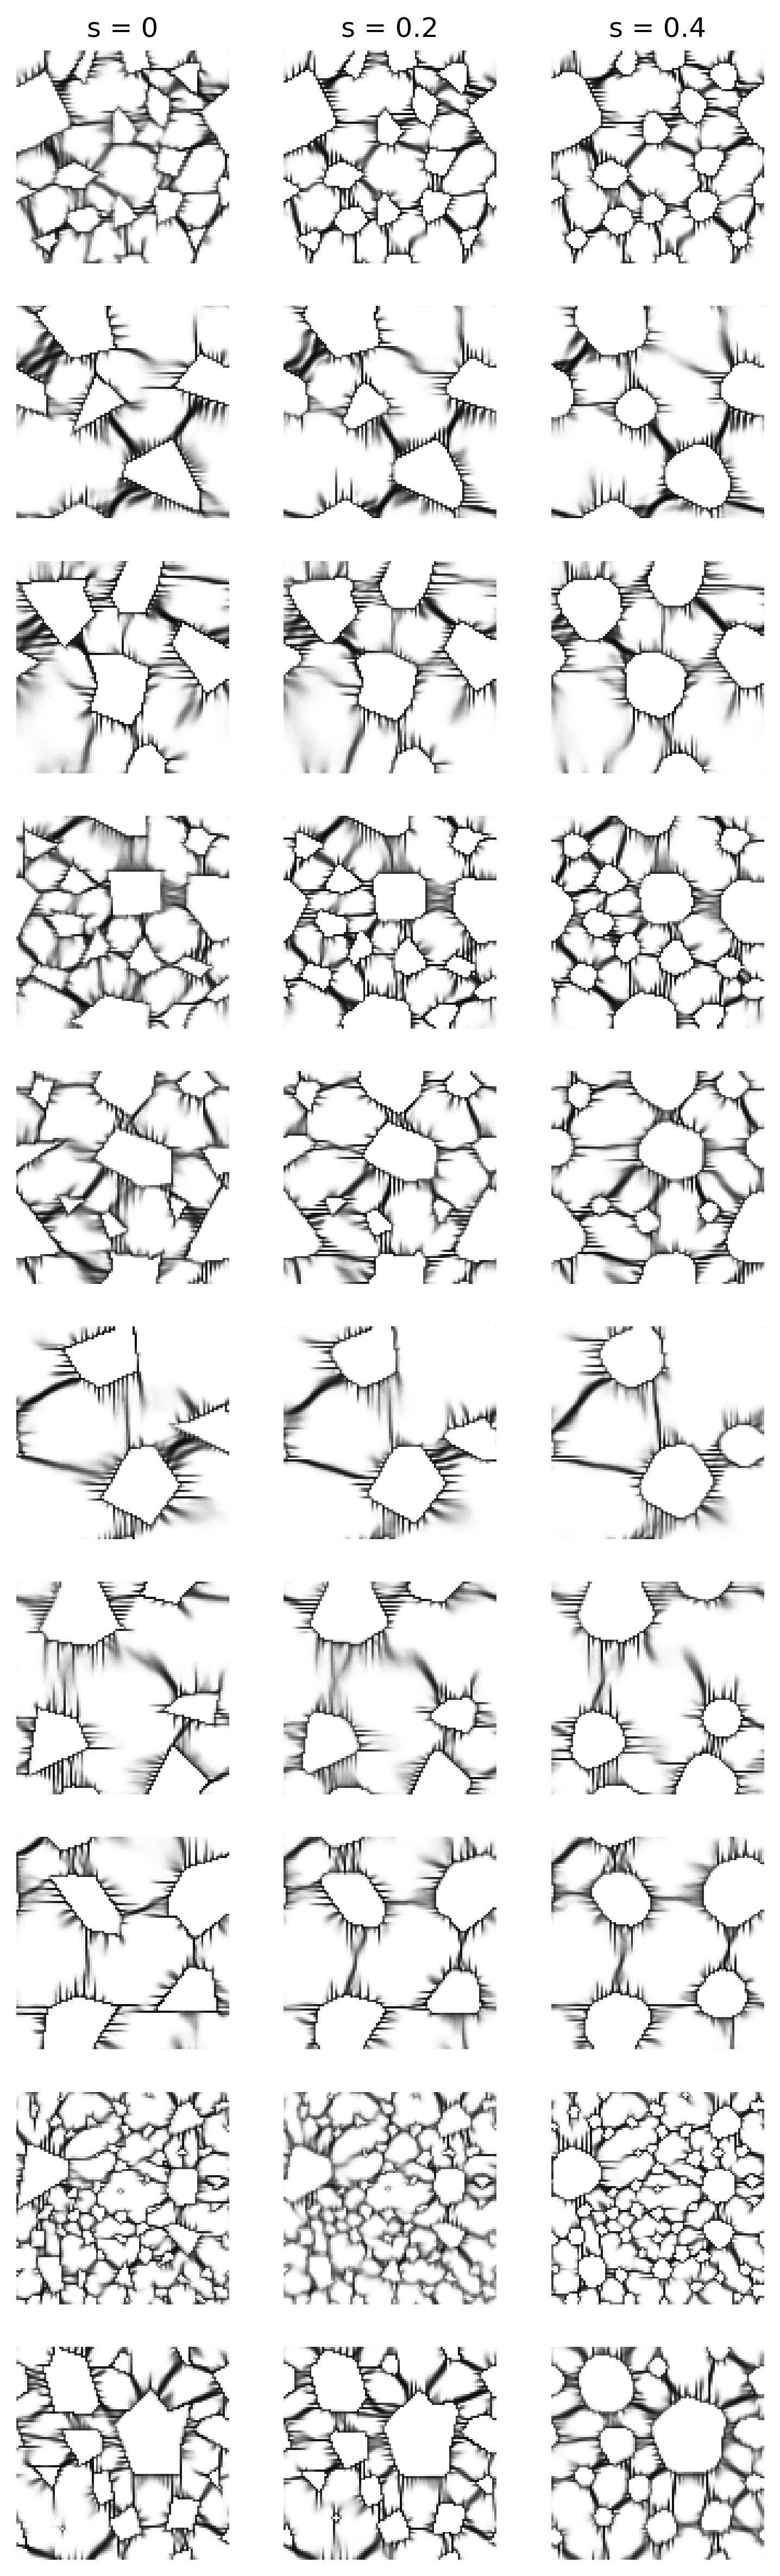

In [89]:
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(6, 20), dpi=300)
for j in range(10*3):
    axs.flat[j].imshow(all_damage[j], cmap='Greys', vmin=0, vmax=1)
    axs.flat[j].set_axis_off()
axs.flat[0].set_title('s = 0')
axs.flat[1].set_title('s = 0.2')
axs.flat[2].set_title('s = 0.4')

In [8]:
from sklearn.mixture import GaussianMixture
X = np.vstack((volume[:,0], shrinkage[:,0])).T
X = X[~np.isnan(X)]
X = X.reshape((-1,2))
X[:,0] /= X[:,0].max() - X[:,0].min()
X[:,1] /= X[:,1].max() - X[:,1].min()
gm = GaussianMixture(n_components=3, covariance_type='full').fit(X)
group = gm.predict(X)

c:\Users\Jorge\.conda\envs\home\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Text(0, 0.5, 'shrinkage')

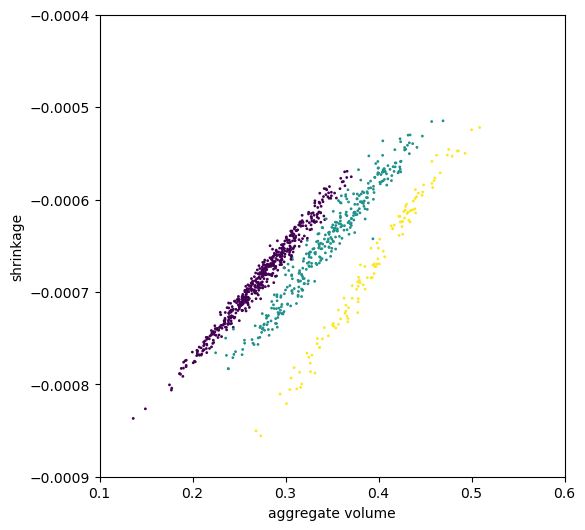

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
nan_values = np.isnan(volume[:,0])
plt.scatter(volume[~nan_values,0], shrinkage[~nan_values,1], s=1, c=group)
plt.xlim([0.1, 0.6])
plt.ylim([-0.0009, -0.0004])
plt.xlabel('aggregate volume')
plt.ylabel('shrinkage')

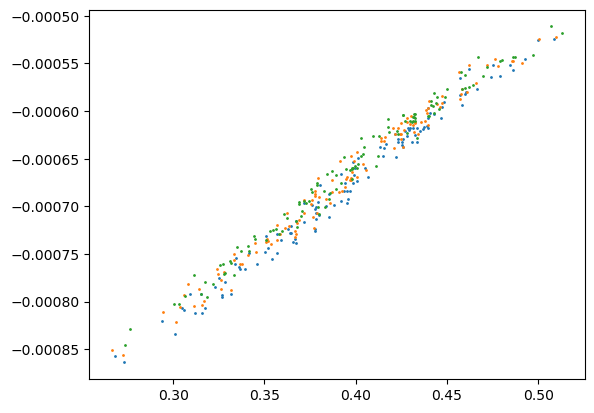

In [38]:
#cluster 1
volume_1 = volume[~nan_values]
shrinkage_1 = shrinkage[~nan_values]
stiffness_1 = stiffness[~nan_values]
damage_1 = total_damage[~nan_values]
volume_1 = volume_1[np.where(group==0, True, False)].squeeze()
shrinkage_1 = shrinkage_1[np.where(group==0, True, False)].squeeze()
stiffness_1 = stiffness_1[np.where(group==0, True, False)].squeeze()
damage_1 = damage_1[np.where(group==0, True, False)].squeeze()
for i in range(3):
    plt.scatter(volume_1[:,i], shrinkage_1[:,i], s=1)

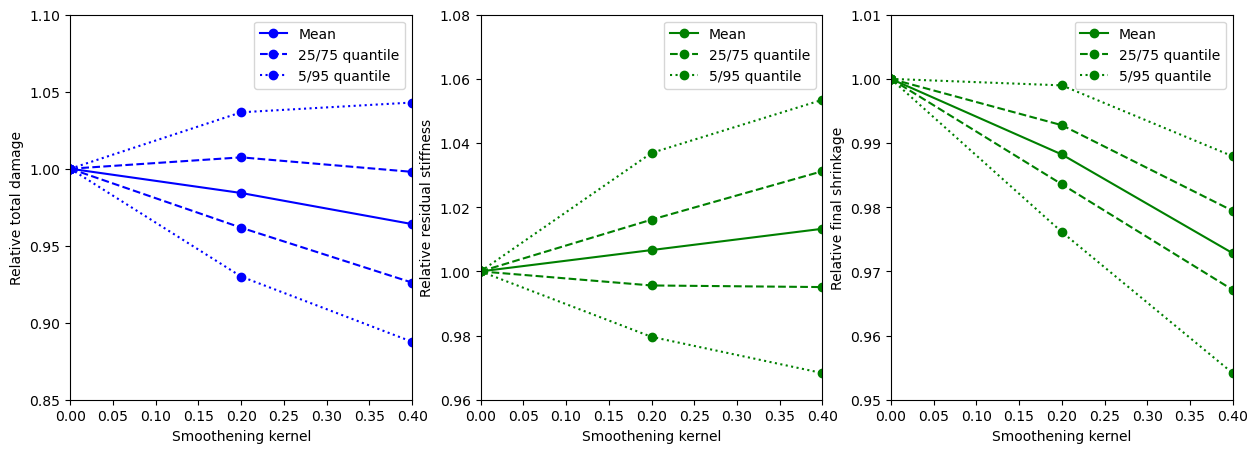

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
rel_damage_1 = damage_1.T/damage_1[:,0]
rel_shrinkage_1 = shrinkage_1.T/shrinkage_1[:,0]
rel_stiffness_1 = stiffness_1.T/stiffness_1[:,0]

axs[0].plot([0,0.2,0.4], np.mean(rel_damage_1,axis=1), 'b-o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_1, 0.25, axis=1), 'b--o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_1, 0.05, axis=1), 'b:o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_1, 0.75, axis=1), 'b--o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_1, 0.95, axis=1), 'b:o')
axs[0].set_ylabel('Relative total damage')
axs[0].set_ylim([0.85, 1.1])

axs[1].plot([0,0.2,0.4], np.mean(rel_stiffness_1,axis=1), 'g-o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_1, 0.25, axis=1), 'g--o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_1, 0.05, axis=1), 'g:o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_1, 0.75, axis=1), 'g--o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_1, 0.95, axis=1), 'g:o')
axs[1].set_ylabel('Relative residual stiffness')
axs[1].set_ylim([0.96, 1.08])

axs[2].plot([0,0.2,0.4], np.mean(rel_shrinkage_1,axis=1), 'g-o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_1, 0.25, axis=1), 'g--o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_1, 0.05, axis=1), 'g:o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_1, 0.75, axis=1), 'g--o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_1, 0.95, axis=1), 'g:o')
axs[2].set_ylabel('Relative final shrinkage')
axs[2].set_ylim([0.95, 1.01])


for i in range(3):
    axs[i].legend(['Mean', '25/75 quantile', '5/95 quantile'])
    axs[i].set_xlim([0, 0.4])
    axs[i].set_xlabel('Smoothening kernel')


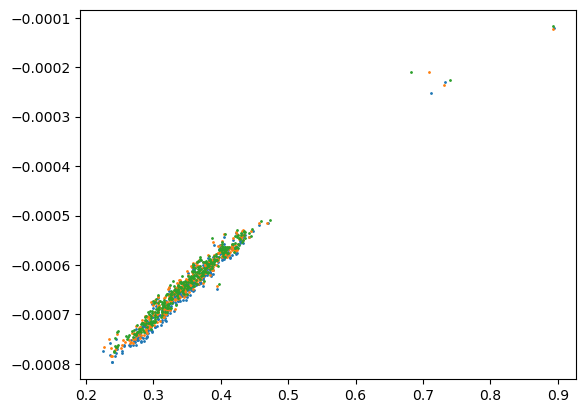

In [56]:
#cluster 2
volume_2 = volume[~nan_values]
shrinkage_2 = shrinkage[~nan_values]
stiffness_2 = stiffness[~nan_values]
damage_2 = total_damage[~nan_values]
volume_2 = volume_2[np.where(group==1, True, False)].squeeze()
shrinkage_2 = shrinkage_2[np.where(group==1, True, False)].squeeze()
stiffness_2 = stiffness_2[np.where(group==1, True, False)].squeeze()
damage_2 = damage_2[np.where(group==1, True, False)].squeeze()
for i in range(3):
    plt.scatter(volume_2[:,i], shrinkage_2[:,i], s=1)

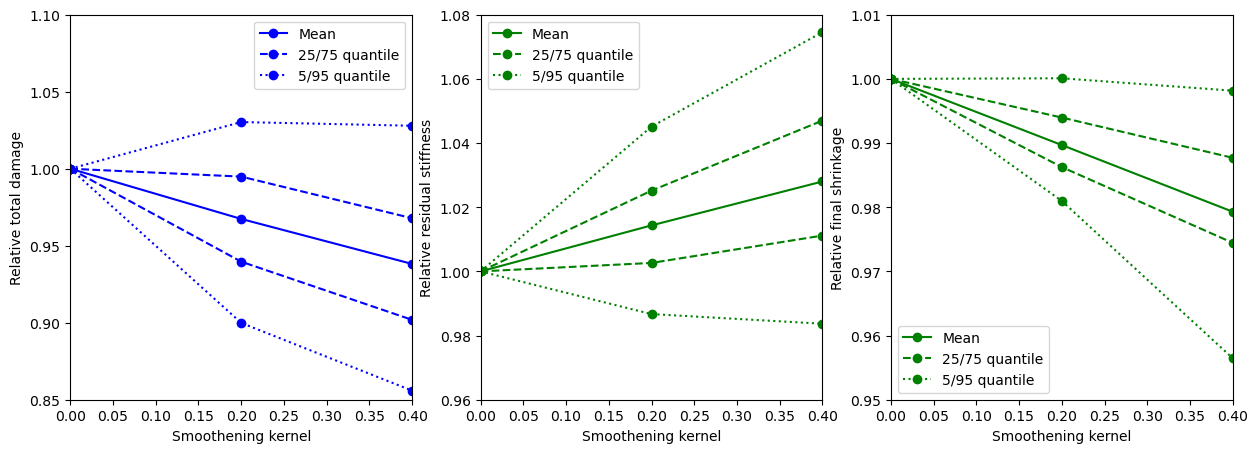

In [82]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
rel_damage_2 = damage_2.T/damage_2[:,0]
rel_shrinkage_2 = shrinkage_2.T/shrinkage_2[:,0]
rel_stiffness_2 = stiffness_2.T/stiffness_2[:,0]

axs[0].plot([0,0.2,0.4], np.mean(rel_damage_2,axis=1), 'b-o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_2, 0.25, axis=1), 'b--o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_2, 0.05, axis=1), 'b:o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_2, 0.75, axis=1), 'b--o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_2, 0.95, axis=1), 'b:o')
axs[0].set_ylabel('Relative total damage')
axs[0].set_ylim([0.85, 1.1])

axs[1].plot([0,0.2,0.4], np.mean(rel_stiffness_2,axis=1), 'g-o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_2, 0.25, axis=1), 'g--o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_2, 0.05, axis=1), 'g:o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_2, 0.75, axis=1), 'g--o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_2, 0.95, axis=1), 'g:o')
axs[1].set_ylabel('Relative residual stiffness')
axs[1].set_ylim([0.96, 1.08])

axs[2].plot([0,0.2,0.4], np.mean(rel_shrinkage_2,axis=1), 'g-o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_2, 0.25, axis=1), 'g--o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_2, 0.05, axis=1), 'g:o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_2, 0.75, axis=1), 'g--o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_2, 0.95, axis=1), 'g:o')
axs[2].set_ylabel('Relative final shrinkage')
axs[2].set_ylim([0.95, 1.01])

for i in range(3):
    axs[i].legend(['Mean', '25/75 quantile', '5/95 quantile'])
    axs[i].set_xlim([0, 0.4])
    axs[i].set_xlabel('Smoothening kernel')


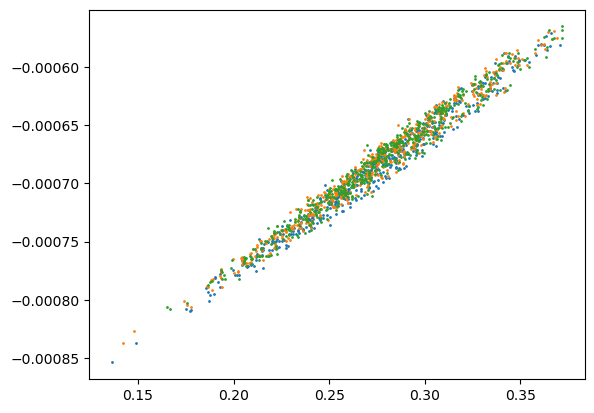

In [72]:
#cluster 3
volume_3 = volume[~nan_values]
shrinkage_3 = shrinkage[~nan_values]
stiffness_3 = stiffness[~nan_values]
damage_3 = total_damage[~nan_values]
volume_3 = volume_3[np.where(group==2, True, False)].squeeze()
shrinkage_3 = shrinkage_3[np.where(group==2, True, False)].squeeze()
stiffness_3 = stiffness_3[np.where(group==2, True, False)].squeeze()
damage_3 = damage_3[np.where(group==2, True, False)].squeeze()
for i in range(3):
    plt.scatter(volume_3[:,i], shrinkage_3[:,i], s=1)

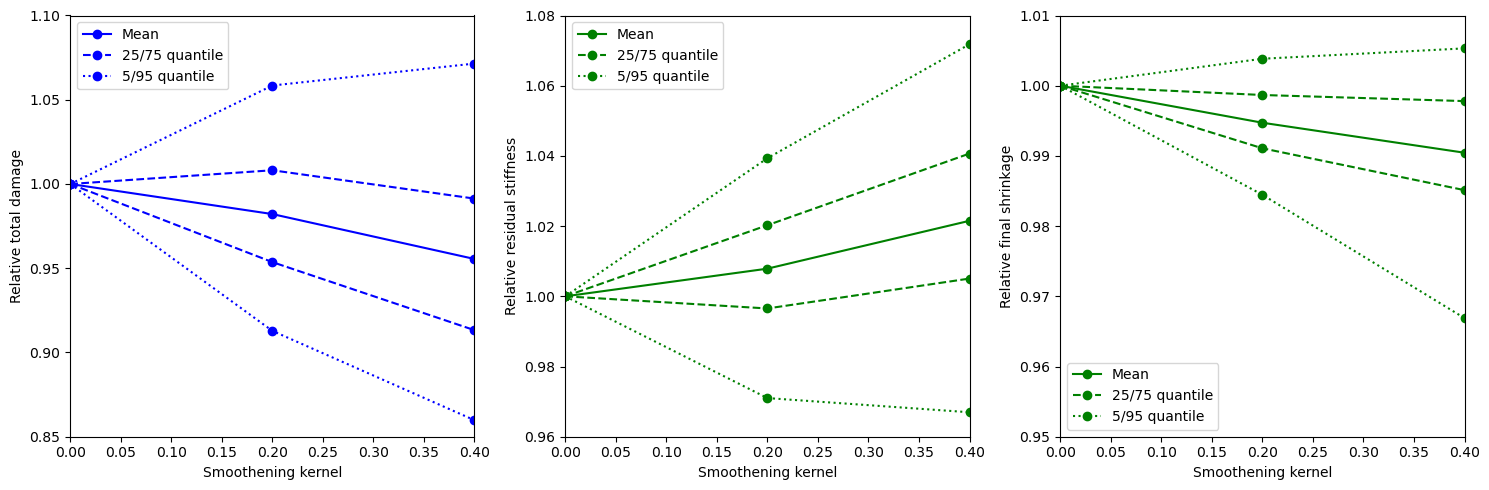

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=100)
rel_damage_3 = damage_3.T/damage_3[:,0]
rel_shrinkage_3 = shrinkage_3.T/shrinkage_3[:,0]
rel_stiffness_3 = stiffness_3.T/stiffness_3[:,0]

axs[0].plot([0,0.2,0.4], np.mean(rel_damage_3,axis=1), 'b-o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_3, 0.25, axis=1), 'b--o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_3, 0.05, axis=1), 'b:o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_3, 0.75, axis=1), 'b--o')
axs[0].plot([0,0.2,0.4], np.quantile(rel_damage_3, 0.95, axis=1), 'b:o')
axs[0].set_ylabel('Relative total damage')
axs[0].set_ylim([0.85, 1.1])

axs[1].plot([0,0.2,0.4], np.mean(rel_stiffness_3,axis=1), 'g-o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_3, 0.25, axis=1), 'g--o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_3, 0.05, axis=1), 'g:o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_3, 0.75, axis=1), 'g--o')
axs[1].plot([0,0.2,0.4], np.quantile(rel_stiffness_3, 0.95, axis=1), 'g:o')
axs[1].set_ylabel('Relative residual stiffness')
axs[1].set_ylim([0.96, 1.08])

axs[2].plot([0,0.2,0.4], np.mean(rel_shrinkage_3,axis=1), 'g-o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_3, 0.25, axis=1), 'g--o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_3, 0.05, axis=1), 'g:o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_3, 0.75, axis=1), 'g--o')
axs[2].plot([0,0.2,0.4], np.quantile(rel_shrinkage_3, 0.95, axis=1), 'g:o')
axs[2].set_ylabel('Relative final shrinkage')
axs[2].set_ylim([0.95, 1.01])

for i in range(3):
    axs[i].legend(['Mean', '25/75 quantile', '5/95 quantile'])
    axs[i].set_xlim([0, 0.4])
    axs[i].set_xlabel('Smoothening kernel')

plt.tight_layout()